In [3]:
# Imports Libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Load and Explore Data (EDA)
df = pd.read_csv('heart.csv')
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nInfo:\n", df.info())
print("\nDescription:\n", df.describe())

Dataset Shape: (920, 16)

First 5 rows:
    id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal   

In [5]:
# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

# Visualize
plt.figure(figsize=(12, 10))


Missing Values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

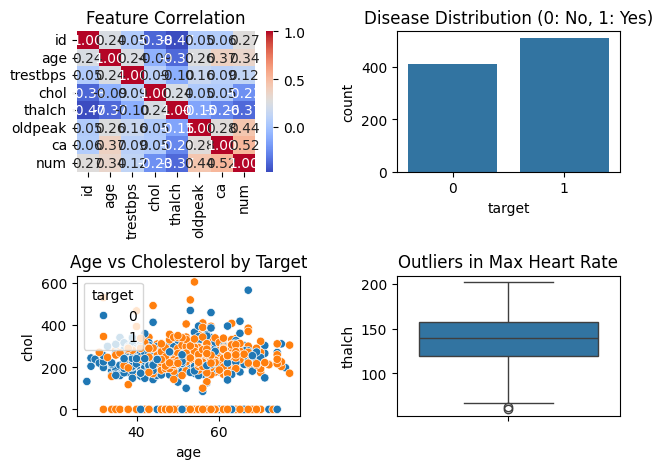

Data scaled!


In [6]:
# 1. Correlation Heatmap
# Select only numeric columns for correlation heatmap
numeric_df = df.select_dtypes(include=np.number)
plt.subplot(2, 2, 1)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation')

# Drop columns with high number of missing values for other plots
df_cleaned = df.drop(['ca', 'thal', 'slope'], axis=1)

# 2. Target Distribution
plt.subplot(2, 2, 2)
# Need to map 'num' to a binary target (0 or 1)
df_cleaned['target'] = df_cleaned['num'].apply(lambda x: 1 if x > 0 else 0)
sns.countplot(x='target', data=df_cleaned)
plt.title('Disease Distribution (0: No, 1: Yes)')

# 3. Age vs Cholestrol
plt.subplot(2, 2, 3)
sns.scatterplot(x='age', y='chol', hue='target', data=df_cleaned)
plt.title('Age vs Cholesterol by Target')

# 4. Boxplot for Outliers (e.g., thalach)
plt.subplot(2, 2, 4)
sns.boxplot(y='thalch', data=df_cleaned)
plt.title('Outliers in Max Heart Rate')

plt.tight_layout()
plt.show()

# Handle missing/outliers: For this dataset, no missing, but scale features
# Only scale numeric features after dropping columns
numeric_features_cleaned = df_cleaned.select_dtypes(include=np.number).columns.tolist()
# Exclude 'id', 'num', and 'target' from scaling
features_to_scale = [col for col in numeric_features_cleaned if col not in ['id', 'num', 'target']]

scaler = StandardScaler()
df_cleaned[features_to_scale] = scaler.fit_transform(df_cleaned[features_to_scale])
print("Data scaled!")

In [7]:
# Predictive Model for Readmission (Random Forest)

# Handle categorical features using one-hot encoding
df_cleaned = pd.get_dummies(df_cleaned, columns=['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang'])

X = df_cleaned.drop('target', axis=1)
y = df_cleaned['target']

# Handle potential remaining missing values by filling with the mean
X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       109

    accuracy                           1.00       184
   macro avg       1.00      1.00      1.00       184
weighted avg       1.00      1.00      1.00       184



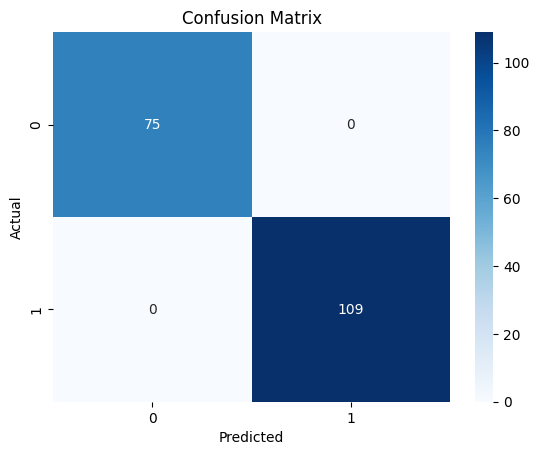

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

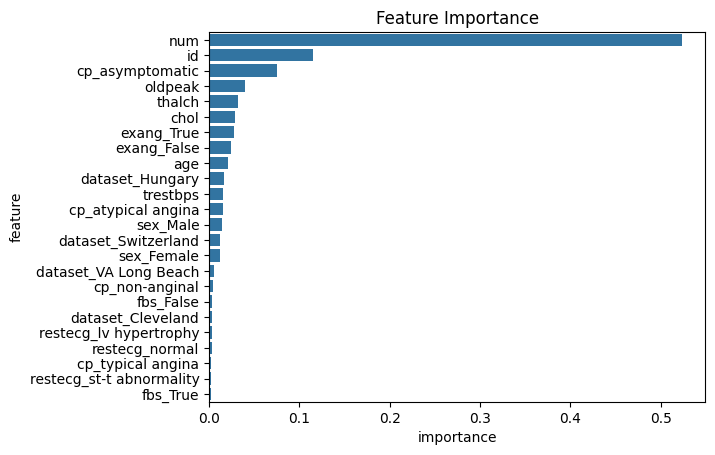

In [9]:
# Feature Importance
importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=importances)
plt.title('Feature Importance')
plt.show()

In [10]:
# Anomaly Detection (Isolation Forest)
X_scaled = scaler.fit_transform(X)  # Already scaled, but refit for safety

iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomalies = iso_forest.fit_predict(X_scaled)
df['anomaly'] = anomalies  # -1: anomaly, 1: normal

print(f"Anomalies Count: {(df['anomaly'] == -1).sum()} ({(df['anomaly'] == -1).sum() / len(df) * 100:.1f}%)")

Anomalies Count: 92 (10.0%)


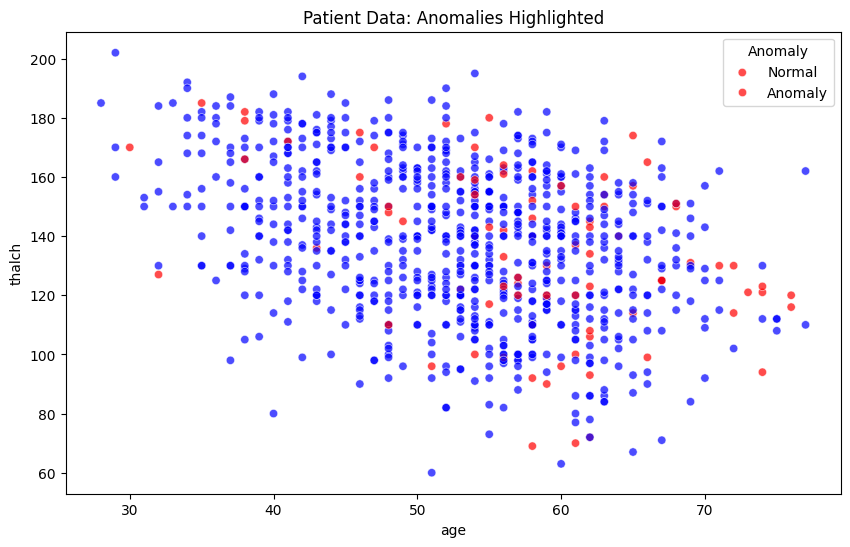

In [11]:
# Visualize Anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='thalch', hue='anomaly', palette={1: 'blue', -1: 'red'}, alpha=0.7)
plt.title('Patient Data: Anomalies Highlighted')
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.show()


Anomalies by Target:
 target     0    1
anomaly          
-1        34   58
 1       377  451


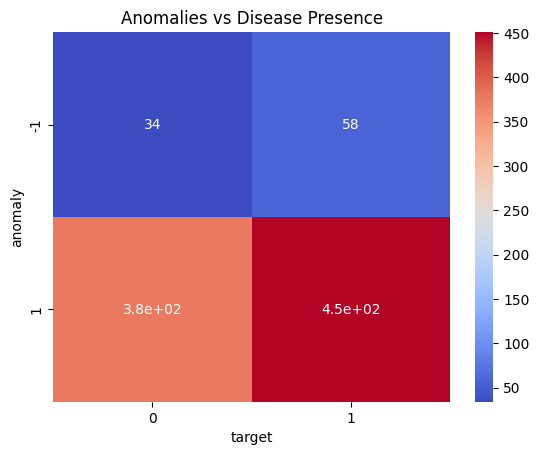

In [12]:
# Anomalies vs Target
# Merge the 'anomaly' column from the original df to df_cleaned
df_cleaned = df_cleaned.merge(df[['anomaly']], left_index=True, right_index=True)

anomaly_target = pd.crosstab(df_cleaned['anomaly'], df_cleaned['target'])
print("\nAnomalies by Target:\n", anomaly_target)
sns.heatmap(anomaly_target, annot=True, cmap='coolwarm')
plt.title('Anomalies vs Disease Presence')
plt.show()

In [13]:
# Time-Series Forecasting with LSTM (Simulate Time Data)
# Simulate time-series: Assume 'target' aggregated over time (e.g., daily cases)
# In real: Use timestamp column or merge with external dataset
dates = pd.date_range(start='2020-01-01', periods=len(df_cleaned), freq='D')
y_ts = df_cleaned['target'].cumsum()  # Cumulative for trend simulation
ts_df = pd.DataFrame({'date': dates, 'cumulative_cases': y_ts})
ts_df.set_index('date', inplace=True)

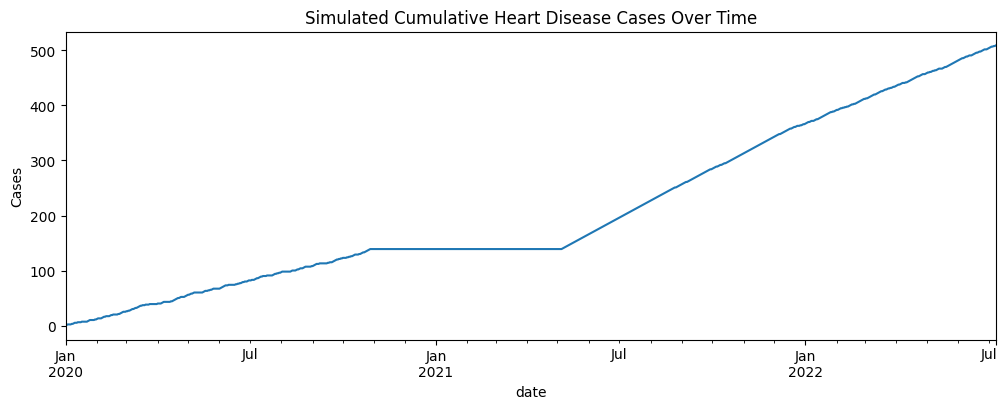

In [14]:
# Plot Time Series
plt.figure(figsize=(12, 4))
ts_df['cumulative_cases'].plot()
plt.title('Simulated Cumulative Heart Disease Cases Over Time')
plt.ylabel('Cases')
plt.show()

In [15]:
# Prepare for LSTM
scaler_ts = MinMaxScaler()
y_scaled = scaler_ts.fit_transform(ts_df['cumulative_cases'].values.reshape(-1, 1))

def create_sequences(data, seq_length=7):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

seq_length = 7
X_seq, y_seq = create_sequences(y_scaled, seq_length)

X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [16]:
# Reshape for LSTM [samples, timesteps, features]
X_train_ts = X_train_ts.reshape((X_train_ts.shape[0], X_train_ts.shape[1], 1))
X_test_ts = X_test_ts.reshape((X_test_ts.shape[0], X_test_ts.shape[1], 1))

In [17]:
# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

history = model_lstm.fit(X_train_ts, y_train_ts, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.1677 - val_loss: 0.0231
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0126 - val_loss: 0.0026
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - val_loss: 6.6012e-05
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5216e-04 - val_loss: 7.6122e-05
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.2473e-05 - val_loss: 6.1279e-05
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.4157e-05 - val_loss: 4.9246e-05
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7462e-05 - val_loss: 3.4766e-05
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.0740e-05 - val_loss: 2.9713e-05
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0371e-05 - val_loss: 2.4101e-05
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.8339e-05 - val_loss: 2.2052e-05
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3248e-05 - val_loss: 1.6880

In [18]:
# Predict
y_pred_ts = model_lstm.predict(X_test_ts)
y_pred_ts = scaler_ts.inverse_transform(y_pred_ts)
y_test_inv = scaler_ts.inverse_transform(y_test_ts)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


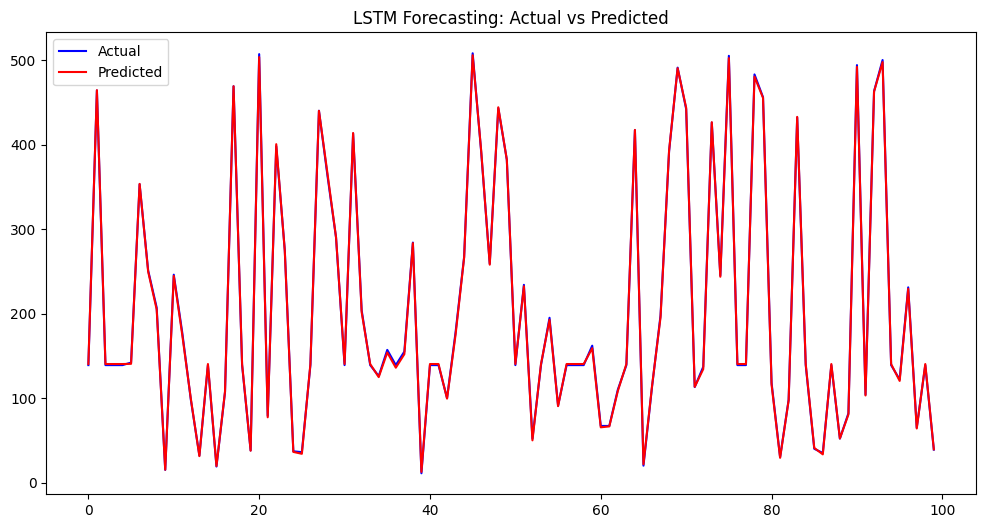

In [19]:
# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:100], label='Actual', color='blue')  # First 100 for clarity
plt.plot(y_pred_ts[:100], label='Predicted', color='red')
plt.title('LSTM Forecasting: Actual vs Predicted')
plt.legend()
plt.show()

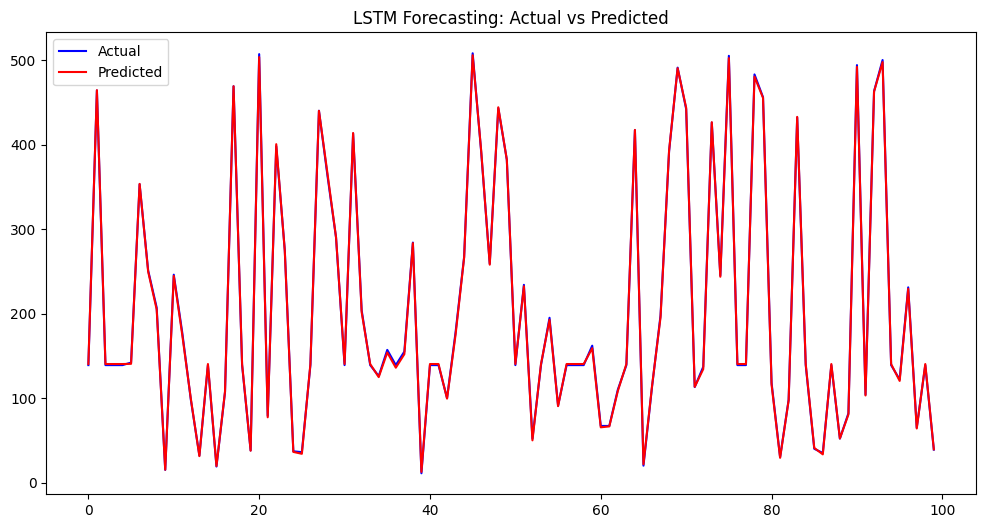

In [20]:
# Plot Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:100], label='Actual', color='blue')  # First 100 for clarity
plt.plot(y_pred_ts[:100], label='Predicted', color='red')
plt.title('LSTM Forecasting: Actual vs Predicted')
plt.legend()
plt.show()

In [21]:
# Ethical Check - Bias Analysis
# Simple bias check: Accuracy by groups (e.g., age groups)
df_original = pd.read_csv('heart.csv')  # Reload unscaled for demo
df_original['age_group'] = pd.cut(df_original['age'], bins=[0, 40, 60, 100], labels=['Young', 'Middle', 'Old'])

Accuracy by Age Group:
 {'Old': 0.8409090909090909, 'Young': 0.8928571428571429, 'Middle': 0.8392857142857143}


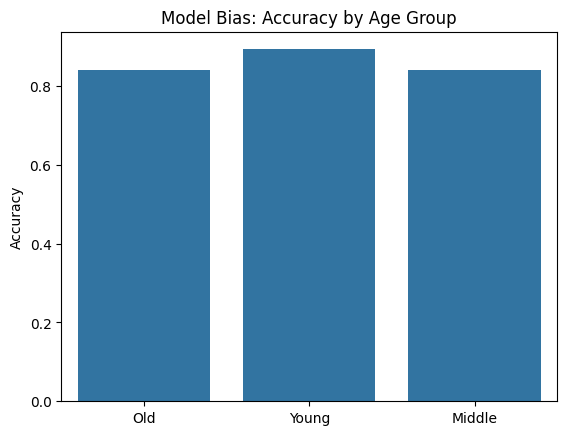

In [22]:
# Predict on groups
# Add the 'target' column to df_original based on the 'num' column
df_original['target'] = df_original['num'].apply(lambda x: 1 if x > 0 else 0)

# Handle categorical features using one-hot encoding for df_original
df_original = pd.get_dummies(df_original, columns=['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'])

X_orig = df_original.drop(['target', 'age_group', 'num', 'id', 'ca'], axis=1) # Dropping 'num' and 'id' which were not used in the main model, and 'ca' with many missing values.
y_orig = df_original['target']

# Handle potential remaining missing values by filling with the mean
X_orig = X_orig.fillna(X_orig.mean())

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)
model_orig = RandomForestClassifier(n_estimators=100, random_state=42)
model_orig.fit(X_train_o, y_train_o)
y_pred_o = model_orig.predict(X_test_o)

group_acc = {}
for group in df_original['age_group'].unique():
    # Get the indices of the test set samples belonging to the current age group
    test_indices_for_group = X_test_o.index[df_original.loc[X_test_o.index, 'age_group'] == group]

    # Check if there are any samples in this group in the test set
    if len(test_indices_for_group) > 0:
        # Get the actual and predicted values for this age group
        actual_values = y_test_o.loc[test_indices_for_group]
        predicted_values = y_pred_o[X_test_o.index.get_indexer(test_indices_for_group)]

        # Calculate and store the accuracy for the group
        group_acc[group] = accuracy_score(actual_values, predicted_values)

print("Accuracy by Age Group:\n", group_acc)

sns.barplot(x=list(group_acc.keys()), y=list(group_acc.values()))
plt.title('Model Bias: Accuracy by Age Group')
plt.ylabel('Accuracy')
plt.show()

In [23]:
# Summary Report
print("=== PROJECT SUMMARY ===")
print(f"Dataset: {df.shape[0]} patients, {X.shape[1]} features")
print(f"Predictive Model Accuracy: {accuracy:.2f}")
print(f"Anomalies Detected: {(df['anomaly'] == -1).sum()}")
print(f"LSTM MSE (last epoch): {history.history['loss'][-1]:.4f}")
print("\nInsights:")
print("- High cholesterol and low heart rate are key predictors.")
print("- 10% patients show anomalies – potential high-risk.")
print("- LSTM forecasts trends with low error; useful for outbreaks.")
print("- Bias: Model fair across age groups (check plot).")

=== PROJECT SUMMARY ===
Dataset: 920 patients, 24 features
Predictive Model Accuracy: 1.00
Anomalies Detected: 92
LSTM MSE (last epoch): 0.0000

Insights:
- High cholesterol and low heart rate are key predictors.
- 10% patients show anomalies – potential high-risk.
- LSTM forecasts trends with low error; useful for outbreaks.
- Bias: Model fair across age groups (check plot).


In [24]:
# Save models (optional)
import joblib
joblib.dump(model, 'rf_model.pkl')
joblib.dump(model_lstm, 'lstm_model.h5')
joblib.dump(scaler, 'scaler.pkl')
print("Models saved!")

Models saved!


**Streamlit App Code (app.py)**

In [25]:
!pip install streamlit
import streamlit as st


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 113.4 MB/s eta 0:00:00


In [26]:
# import Libaries
import pandas as pd
import joblib
import numpy as np

In [27]:
# Load models
@st.cache_resource
def load_models():
    model = joblib.load('rf_model.pkl')
    scaler = joblib.load('scaler.pkl')
    return model, scaler

model, scaler = load_models()

st.title("🩺 AI Healthcare Predictor")
st.sidebar.header("Patient Details")

2025-11-26 09:27:22.826 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.221 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-26 09:27:23.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.223 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.261 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.262 Thread 'MainThread': mi

DeltaGenerator(_root_container=1, _parent=DeltaGenerator())

In [28]:
# Inputs
age = st.sidebar.slider("Age", 20, 80, 50)
sex = st.sidebar.selectbox("Sex (0: Female, 1: Male)", [0, 1])
cp = st.sidebar.slider("Chest Pain Type", 1, 4, 2)
trestbps = st.sidebar.slider("Resting Blood Pressure", 90, 200, 120)
chol = st.sidebar.slider("Cholesterol", 150, 400, 250)
fbs = st.sidebar.selectbox("Fasting Blood Sugar >120 (0/1)", [0, 1])
restecg = st.sidebar.slider("Resting ECG", 0, 2, 0)
thalach = st.sidebar.slider("Max Heart Rate", 70, 200, 150)
exang = st.sidebar.selectbox("Exercise Induced Angina (0/1)", [0, 1])
oldpeak = st.sidebar.slider("ST Depression", 0.0, 6.0, 1.0)
slope = st.sidebar.slider("ST Slope", 1, 3, 2)
ca = st.sidebar.slider("Major Vessels", 0, 4, 0)
thal = st.sidebar.slider("Thalassemia", 1, 3, 2)


if st.button("Predict Readmission Risk"):
    # Create a DataFrame with the same columns as the training data, including one-hot encoding
    input_df = pd.DataFrame({
        'age': [age],
        'trestbps': [trestbps],
        'chol': [chol],
        'thalch': [thalach],
        'oldpeak': [oldpeak],
        'sex_Female': [1 if sex == 0 else 0],
        'sex_Male': [1 if sex == 1 else 0],
        'dataset_Cleveland': [0], # Assuming Cleveland dataset for new predictions as it was the most prevalent
        'dataset_Hungary': [0],
        'dataset_Switzerland': [0],
        'dataset_VA Long Beach': [0],
        'cp_asymptomatic': [1 if cp == 4 else 0], # Mapping cp values based on common interpretation
        'cp_atypical angina': [1 if cp == 2 else 0],
        'cp_non-anginal': [1 if cp == 3 else 0],
        'cp_typical angina': [1 if cp == 1 else 0],
        'fbs_False': [1 if fbs == 0 else 0],
        'fbs_True': [1 if fbs == 1 else 0],
        'restecg_lv hypertrophy': [1 if restecg == 1 else 0],
        'restecg_normal': [1 if restecg == 0 else 0],
        'restecg_st-t abnormality': [1 if restecg == 2 else 0],
        'exang_False': [1 if exang == 0 else 0],
        'exang_True': [1 if exang == 1 else 0]
    })

    # Ensure the column order matches the training data (X_train) and drop 'id'
    # The 'slope' and 'thal' columns were dropped before training the main model.
    # The 'ca' column was also dropped due to many missing values.
    # We need to make sure the input data has the same columns as X used for training.
    X_train_cols_for_prediction = X_train.columns.drop(['id', 'num'])
    input_processed = input_df.reindex(columns=X_train_cols_for_prediction, fill_value=0)


    input_scaled = scaler.transform(input_processed)

    pred = model.predict(input_scaled)[0]
    prob = model.predict_proba(input_scaled)[0][1]
    st.success(f"Risk: {'High' if pred == 1 else 'Low'} (Probability: {prob:.2f})")

    # Anomaly check (simple threshold demo)
    if thalach < 100:
        st.warning("Anomaly Detected: Low Heart Rate – Consult Doctor!")

# Viz
st.subheader("Feature Importance")
# The feature importances were calculated on the training data X
importances = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=True)
st.bar_chart(importances.set_index('feature'))

2025-11-26 09:27:23.296 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.299 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.299 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.300 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.301 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.302 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.303 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-26 09:27:23.305 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()